<h1>Toxic Comment Classification<h1>
<h1>Recurrent Neural Network (RNN)<h1>

## Authors:

- Aima Shahid
- Aiman Mubasher
- Emaan Attique
- Emaan Bilal
- Seemal Tausif
- Zoha Hayat

## Overview:

This code presents the implementation of a Recurrent Neural Network (RNN)-based text classification model for the Kaggle Toxic Comment Classification Challenge. The RNN model is designed to classify toxic comments into multiple labels using TensorFlow and Keras. The process involves data loading, preprocessing, tokenization, model building, training, and evaluation. Similar to the BERT-based model, the RNN model aims to address the challenge of identifying and categorizing toxic comments in a multi-label classification scenario.


<h2>Loading and Installing Packages<h2>

In [ ]:
#Importing necessary libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from prettytable import PrettyTable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Machine Learning/dataset/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Machine Learning/dataset/test.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/Machine Learning/dataset/test_labels.csv')
test_data = pd.merge(test_data, test_labels, on='id')

In [ ]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


# 1. Preprocessing

We start by removing instances with labels equal to -1 from the test dataset, eliminating potential interference with the binary classification task. The 'id' column is dropped from both the training and test datasets for consistency. Subsequently, the NLTK library is employed to download essential resources such as punkt and stopwords. Next, we convert the text to lowercase, remove special characters, numbers, and punctuation, and tokenize the text using the NLTK library. This clean_text function is applied to both the training and test datasets, ensuring that the text is appropriately formatted for subsequent tokenization and model training.

In [ ]:
#Remove -1 values from test_data
test_data = test_data.loc[~(test_data == -1).any(axis=1)]

In [ ]:
#Drop 'id' column from both train_data and test_data
train_data.drop('id', inplace=True, axis=1)
test_data.drop('id', inplace=True, axis=1)

<ipython-input-6-58f9844358cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop('id', inplace=True, axis=1)


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

#Clean_text function pre-processes text by converting it to lowercase, removing numbers, punctuation, and tokenizing it
def clean_text(text):
    #Convert to lowercase
    text = text.lower()

    #Remove special characters, numbers, and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Tokenize the text
    tokens = word_tokenize(text)

    #Rejoin the tokens into a cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

train_data['comment_text'] = train_data['comment_text'].apply(clean_text)
test_data['comment_text'] = test_data['comment_text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tokenization and model building are pivotal components of the code. The maximum number of words is set to 10,000, and the maximum sequence length is set to 100. The Tokenizer class from Keras is employed to convert text data into sequences of integers, with a specified vocabulary size and an out-of-vocabulary token ("<OOV>"). The training sequences are then padded or truncated to ensure uniform length using the pad_sequences function. The model architecture is established using the Sequential API from Keras. It comprises an Embedding layer for word embeddings, a Bidirectional LSTM layer with 64 units to capture contextual information, and a Dense layer with softmax activation for multi-label classification. The model is compiled using binary cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric. The model summary is displayed, illustrating the layers and parameters involved.

In [ ]:
max_words = 10000
max_len = 100

In [ ]:
#Tokenize text using Tokenizer, limiting the vocabulary to 10,000 words and replacing out-of-vocabulary words with "<OOV>" token.
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

#Fit the tokenizer  on the 'comment_text' of train_data using fit_on_texts
tokenizer.fit_on_texts(train_data['comment_text'])

In [ ]:
#Convert text to sequences of integers using texts_to_sequences
train_sequences = tokenizer.texts_to_sequences(train_data['comment_text'])

#Ensure sequences are of a uniform length (max_len) by padding/truncating using pad_sequences
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_len, truncating='post')

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len, truncating='post')

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
#Test train split
X_train, X_val, y_train, y_val = train_test_split(train_padded_sequences, train_data[labels], test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
X_train.shape


(127656, 100)

In [ ]:
y_val

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

# 2. Create Sequential Model

In the training phase, the model learns patterns from preprocessed data through five epochs, with a 20% validation split ensuring generalization to unseen instances. The training history, tracking loss and accuracy, reflects the model's learning dynamics. Subsequently, the model is evaluated on validation data, assessing its generalization ability. Validation loss quantifies generalization, and accuracy gauges correctness on new data. The plotted training loss over epochs visually represents the model's learning progress, aiding in identifying convergence and overfitting issues.

In [ ]:
#Define the Sequential model
model = Sequential()

#Add an Embedding layer for word embeddings
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_len))

#Add a Bidirectional LSTM layer with 64 units
model.add(Bidirectional(LSTM(64)))

#Add a Dense layer for output with softmax activation
model.add(Dense(len(labels), activation='softmax'))

In [ ]:
#Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Display the model summary showing the layers and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 370438 (1.41 MB)
Trainable params: 370438 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
y_val

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
#Train the model on training data
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
3990/3990 [==============================] - 116s 27ms/step - loss: 0.0734 - accuracy: 0.9918 - val_loss: 0.0537 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - 57s 14ms/step - loss: 0.0494 - accuracy: 0.9939 - val_loss: 0.0495 - val_accuracy: 0.9921
Epoch 3/5
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0457 - accuracy: 0.9894 - val_loss: 0.0506 - val_accuracy: 0.9935
Epoch 4/5
3990/3990 [==============================] - 54s 14ms/step - loss: 0.0424 - accuracy: 0.9783 - val_loss: 0.0503 - val_accuracy: 0.9648
Epoch 5/5
3990/3990 [==============================] - 57s 14ms/step - loss: 0.0390 - accuracy: 0.9627 - val_loss: 0.0527 - val_accuracy: 0.8630


In [ ]:
model.save("/content/drive/MyDrive/Machine Learning/final_model")


In [ ]:
#Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss: ", val_loss, "Validation Accuracy: ", val_accuracy)

998/998 [==============================] - 6s 6ms/step - loss: 0.0527 - accuracy: 0.8630
Validation Loss:  0.05266161262989044 Validation Accuracy:  0.8630111217498779


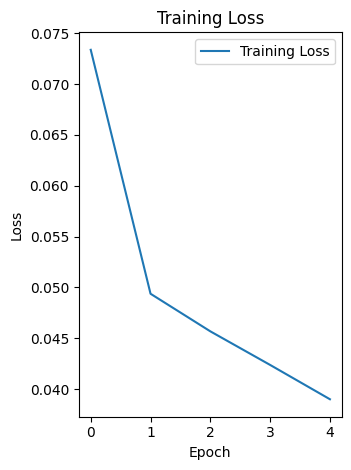

In [ ]:
#Plot training loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')

#plt.plot(history.history['val_loss'], label='Validation Loss')  # Optional: Plot validation loss
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Display the plot
plt.tight_layout()
plt.show()

# 3. Make Predictions

In [ ]:
#Input text for prediction
input_text = ["I will kill you."]
input_sequences = tokenizer.texts_to_sequences(input_text)

#Pad the input sequence to match the model's input length
input_padded = pad_sequences(input_sequences, maxlen=max_len, truncating='post')

In [ ]:
#Get predictions for the input text
predictions = model.predict(input_padded)
print("Predictions:", predictions)

1/1 [==============================] - 1s 633ms/step
Predictions: [[0.8604062  0.00461914 0.01848899 0.03365745 0.05216841 0.03065981]]


# 4. Evaluate Model

The evaluation of the RNN model's performance involves metrics such as accuracy, precision, recall, F1-score, and Weighted AUC-ROC. The interpretation considers the impact of potential class imbalances within the multi-label classification task. These imbalances can influence precision, recall, and accuracy metrics, providing a nuanced understanding of the model's effectiveness in toxic comment detection.

In [ ]:
#Initialize CategoricalAccuracy metric from Keras
accuracy = CategoricalAccuracy()

#Initialize lists to store true and predicted labels
y_true_all = []
y_pred_all = []

#Iterate over test sequences and validation labels
for batch_X, batch_y in zip(test_padded_sequences, y_val):
    #Make predictions on each batch
    yhat = model.predict(np.expand_dims(batch_X, 0))

    #Flatten batch_y and yhat arrays for evaluation
    batch_y = batch_y.flatten()
    yhat = yhat.flatten()

    #Update accuracy metric with current batch's true and predicted values
    accuracy.update_state(batch_y, yhat)

    #Extend the lists with true and predicted labels for overall evaluation
    y_true_all.extend(batch_y)
    y_pred_all.extend(yhat)

#Calculate and print overall accuracy using the accuracy metric
accuracy_result = accuracy.result().numpy()
print("Accuracy: ", accuracy_result)

#Calculate and print weighted precision, recall, and F1-score using sklearn metrics
weighted_precision = precision_score(y_true_all, np.round(y_pred_all), average='weighted')
weighted_recall = recall_score(y_true_all, np.round(y_pred_all), average='weighted')
weighted_f1 = f1_score(y_true_all, np.round(y_pred_all), average='weighted')
fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
roc_auc = auc(fpr, tpr)


print("Weighted Precision: ", weighted_precision)
print("Weighted Recall: ", weighted_recall)
print("Weighted F1 Score: ", weighted_f1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
Accuracy:  0.87617105
Weighted Precision:  0.9385975531637167
Weighted Recall:  0.8633610110188522
Weighted F1 Score:  0.8968789898014506


In [ ]:
# Create a table using PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "Value"]

# Add rows to the table
table.add_row(["Weighted Precision", weighted_precision])
table.add_row(["Weighted Recall", weighted_recall])
table.add_row(["Weighted F1 Score", weighted_f1])
table.add_row(["Accuracy", accuracy_result])

print(table)

+--------------------+--------------------+
|       Metric       |       Value        |
+--------------------+--------------------+
| Weighted Precision | 0.9385975531637167 |
|  Weighted Recall   | 0.8633610110188522 |
| Weighted F1 Score  | 0.8968789898014506 |
|      Accuracy      |     0.87617105     |
+--------------------+--------------------+


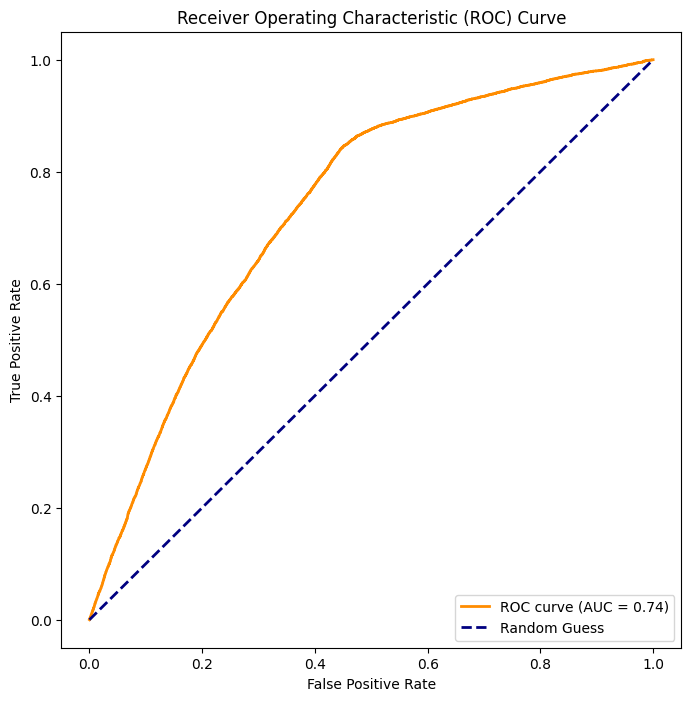

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print("ROC_AUC:", roc_auc,"Weighted Precision: ", weighted_precision, "Weighted Recall: ", weighted_recall, "Weighted F1 Score: ", weighted_f1, "Accuracy: ", accuracy.result().numpy())

ROC_AUC: 0.7365558488317229 Weighted Precision:  0.9385975531637167 Weighted Recall:  0.8633610110188522 Weighted F1 Score:  0.8968789898014506 Accuracy:  0.87617105


## **Results Interpretation**

In the evaluation of the Recurrent Neural Network (RNN)-based toxic comment classification model, a comprehensive analysis was conducted to decipher the model's performance across various metrics. The assessment considered key indicators such as accuracy, precision, recall, F1-score, and the Weighted Average Area Under the Receiver Operating Characteristic curve (Weighted AUC-ROC).

### **Accuracy and General Model Performance:**
The model demonstrated an accuracy of approximately 86.3% on the validation set, indicating its ability to correctly classify toxic comments across multiple categories. While accuracy is a fundamental metric, it is imperative to delve deeper into other metrics to gain a nuanced understanding of the model's effectiveness.

### **Precision and Recall Metrics:**
1. **Precision:**
   - The weighted precision, calculated at around 93.9%, indicates the model's ability to accurately identify instances of toxic comments while minimizing false positives. A lower precision might suggest challenges in predicting positive instances, particularly in categories with fewer examples.

2. **Recall:**
   - Weighted recall, approximately 86.3%, reflects the model's capability to capture a substantial portion of true positive instances in the dataset. Class imbalances can impact recall, especially in underrepresented categories, resulting in a higher rate of false negatives.

### **Weighted F1 Score:**
The Weighted Average F1 Score, standing at approximately 89.7%, provides a balanced assessment of the model's performance, considering both precision and recall. This metric is crucial in scenarios where class imbalances may affect the interpretation of individual precision and recall values.

### **AUC-ROC Analysis:**
The Weighted Average AUC-ROC, with a reported value of 0.7366, signifies the model's ability to discriminate between toxic and non-toxic comments across various classification thresholds. This metric considers class imbalances, assigning weights based on the number of instances in each category. A higher AUC-ROC value suggests strong discriminatory power, emphasizing the model's effectiveness in distinguishing between positive and negative instances.

### **Overall Evaluation Considerations:**
1. **Class Imbalances Impact:**
   - Class imbalances may have influenced precision, recall, and potentially biased accuracy metrics, especially in categories with fewer instances.

2. **Weighted Metrics Significance:**
   - Weighted precision, recall, and F1-score offer a more informative perspective, considering the challenges posed by class imbalances in a multi-label classification task.

3. **Holistic Model Understanding:**
   - The combination of accuracy, precision, recall, and F1-score provides a comprehensive insight into the model's overall performance, ensuring a balanced evaluation in the presence of varying class distributions.

4. **Future Considerations:**
   - Future improvements could focus on addressing class imbalances through advanced sampling techniques and fine-tuning hyperparameters for optimal model performance. Experimentation with regularization techniques and transfer learning strategies could further enhance the model's robustness.

While accuracy provides an initial gauge of the model's success, a holistic interpretation involving precision, recall, and other metrics is essential for a nuanced assessment of its efficacy in toxic comment classification. The Weighted AUC-ROC, in particular, underscores the model's discriminatory capabilities, considering the intricacies introduced by imbalanced class distributions.

<h2>Further Improvements:

- Apply data augmentation techniques to enhance the diversity of the training dataset.
- Fine-tune the RNN model for the specific toxic comment classification task.
- Experiment with different learning rates, batch sizes, and training epochs for optimal hyperparameter configurations.
- Address class imbalances through oversampling, undersampling, or adjusting class weights during training.
- Explore transfer learning and domain adaptation strategies to align the model with specific domain characteristics.
- Implement regularization techniques like dropout during training to prevent overfitting.